In [245]:
"""
Code for accommodating the graph-making need of ECON 3229-2 Money, Banking, and Financial Systems 

University of Missouri-Columbia

Fangda Wang

Fall 2017


https://github.com/vitanova
"""

# I work as teaching assistant for this course, and am told to generate/update lots of figures of macroeconomic
# and monetary time series, mainly from the FRED:
# https://fred.stlouisfed.org/
# although the website has the functionality to plot figures, it's elementary and cannot satisify this course's demand
# and, I am tired of handling excel, since each time I have to build the procedure from the begining
# moreover, there are a number of similar tasks in the foreseeable future, so I decide to write some code 
# to automize the procedure, before it is too late

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#this is a third-party api for manipulating fred data
from fred import Fred

#first, use the api key to get access to fred, all data in dictionary format
#replace with your own key
fr = Fred(api_key='abcdefghijklmnopqrstuvwxyz123456', response_type='dict')

#now, use the series id to get observations
cpi=fr.series.observations(series_id="PCEPI")
aaa=fr.series.observations(series_id="AAA")
nber=fr.series.observations(series_id="USREC")

#convert the dictionary data to data frame
CPI=pd.DataFrame.from_dict(cpi)
AAA=pd.DataFrame.from_dict(aaa)
NBER=pd.DataFrame.from_dict(nber)

#rename columns
CPI.columns = 'date', 'end', 'start', 'cpi'
AAA.columns = 'date', 'end', 'start', 'aaa'
NBER.columns = 'date', 'end', 'start', 'nber'

#merge the two tables and use date as key
al=pd.merge(CPI, AAA, how='left', on='date')
al=pd.merge(al, NBER, how='left', on='date')
al=al.drop('end_x', axis=1)
al=al.drop('start_x', axis=1)
al=al.drop('end_y', axis=1)
al=al.drop('start_y', axis=1)
al=al.drop('end', axis=1)
al=al.drop('start', axis=1)

al.head()

C:\Anaconda3\lib\site-packages\fred\helpers\__init__.py:36: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  frame = frame.convert_objects(convert_numeric=True)
C:\Anaconda3\lib\site-packages\pandas\core\internals.py:3224: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,date,cpi,aaa,nber
0,1959-01-01,17.124,4.12,0
1,1959-02-01,17.138,4.14,0
2,1959-03-01,17.149,4.13,0
3,1959-04-01,17.183,4.23,0
4,1959-05-01,17.191,4.37,0


In [246]:
#to reflect the up-to-date nature of data, we set end date as last available month in fred
#actually, we need data from 1977-07-01, but inflation rate need to be calculated based on last year
#so we get cpi data from 1976
start_date=datetime.date(1976, 7, 1)
end_date=datetime.date(2017, 7, 1)

#since we only plot quarterly data, these monthly observations should be transformed in frequency
index = pd.date_range(start=start_date, end=end_date, freq='3MS')
columns = ['A']
def diff_quarter(d1, d2):
    return (d2.year - d1.year) * 4 + int((d2.month - d1.month)/3)
n_rows=diff_quarter(start_date, end_date) + 1
data = np.array([np.arange(n_rows)]*1).T
df = pd.DataFrame(data, index=index, columns=columns)
df['date']=df.index

#now, use the quarterly format table to extract information from the fred data
new_one=pd.merge(df, al, how='left', on='date')
new_one=new_one.drop('A', axis=1)
new_one.head()

,date,cpi,aaa,nber
0,1976-07-01,32.014,8.56,0
1,1976-10-01,32.541,8.32,0
2,1977-01-01,33.058,7.96,0
3,1977-04-01,33.678,8.04,0
4,1977-07-01,34.216,7.94,0


In [247]:
#add a new column to represent inflation rate, calculated by:
#     pi_t = (p_{t+4}-p_t)/p_t * 100%
# here t is quarterly data, so we add four as a whole year
#WARNING: we should check whether there is missing data for some dates
new_one['shifted_cpi']=new_one.cpi.shift(4)

def infl_rate(x, y):
    return (x-y)/y *100
new_one['inflation']=new_one.apply(lambda row: infl_rate(row['cpi'], row['shifted_cpi']), axis=1)
new_one.set_index('date')

#transform date format from yyyy-mm-dd to yyyy Qq
def tran_date(xx):
    return str(xx.year) + " Q" + str(1+int(xx.month/3))
new_one['new_date']=new_one.apply(lambda row: tran_date(row['date']), axis=1)
t=new_one.drop(new_one.index[0:4])
t=t.drop('cpi', axis=1)
t=t.drop('shifted_cpi', axis=1)

#add the zero line, prep two nber series to facilitate making the shaded area between them
t['zero']=0
t['+nber']=20*t['nber']
t['-nber']=-t['+nber']
t.head()

,date,aaa,nber,inflation,new_date,zero,+nber,-nber
4,1977-07-01,7.94,0,6.878241,1977 Q3,0,0,0
5,1977-10-01,8.04,0,6.536370,1977 Q4,0,0,0
6,1978-01-01,8.41,0,6.633795,1978 Q1,0,0,0
7,1978-04-01,8.56,0,6.654196,1978 Q2,0,0,0
8,1978-07-01,8.88,0,7.005495,1978 Q3,0,0,0


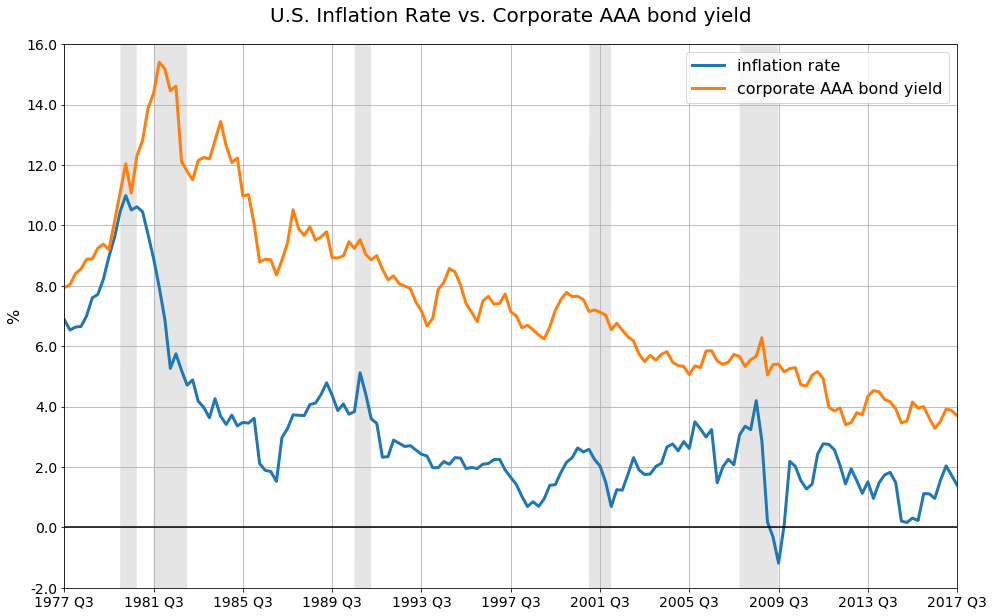

In [248]:
#since fill_between mathod doesnt work well with datetype64, we need to transform it
finally_=t.date.values
fig, ax=plt.subplots(figsize=(16, 10))
ax.plot(finally_, t['inflation'], label='inflation rate', linewidth=3)
ax.plot(finally_, t['aaa'], label='corporate AAA bond yield', linewidth=3)
ax.plot(finally_, t['zero'], color='black', label='_nolegend_')

#transform the shaded area into rectangle
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(finally_, t['+nber'], t['-nber'], facecolor='gray', interpolate=False, transform=trans, alpha=0.2)

#set the horizontal label as transformed data type
ax.set_xlim([t.date[t.index[0]], t.date[t.index[-1]]])
real_date=[]
trans_date=[]
for i in range(11):
    real_date.append(t.date[t.index[16*i]])
    trans_date.append(t.new_date[t.index[16*i]])
ax.set_xticks(real_date)
ax.set_xticklabels(trans_date, fontsize=14)

ax.set_yticklabels(np.linspace(-2, 16, 10), fontsize=14)
ax.grid()
ax.set_ylim(-2, 16)
ax.set_ylabel("%", fontsize=16)
ax.legend(loc='best', fontsize=16)
ax.set_title("U.S. Inflation Rate vs. Corporate AAA bond yield", fontsize=20, position=[.5, 1.03])
plt.show()